<a href="https://colab.research.google.com/github/farhanfuadabir/ASL-DataGlove/blob/main/Model__DL/Model__LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import** Data



In [ ]:
!unzip -q /content/\*.zip


7 archives were successfully processed.


# **Load** Dependencies

In [ ]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import librosa as lb
from joblib import load, dump
from tqdm.notebook import tqdm
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

# **Constants**

In [ ]:
# Get user list
# _, filenames, _ = next(os.walk("/content/Hand-Gesture-Recognition/ContinuousDataAcquisitionPython/Data_032021"))
# users = [os.path.splitext(x)[0] for x in filenames]
# users = sorted(users, key=lambda x: (len(x), x))
users = ['001', '002', '003', '004', '005', '006', '007']
print(users)

['001', '002', '003', '004', '005', '006', '007']


In [ ]:
# Indicate segmentLength, recorditeration according to the 'serialDataAcquisition_segmented.py' script
segmentLength = 150
recorditeration = 10

# ColumnNames according to the 'serialDataAcquisition_segmented.py' script
columnName = ['timestamp', 'user_id',
              'flex_1', 'flex_2', 'flex_3', 'flex_4', 'flex_5',
              'Qw', 'Qx', 'Qy', 'Qz',
              'GYRx', 'GYRy', 'GYRz',
              'ACCx', 'ACCy', 'ACCz',
              'ACCx_body', 'ACCy_body', 'ACCz_body',
              'ACCx_world', 'ACCy_world', 'ACCz_world']

# gestures = get_gesture_names(userPath)
gestures = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
            'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
            'bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry',
            'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']

print('Gesture List: ', gestures)
print('Number of Gestures: ', len(gestures))

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(gestures)
print("Number of Gestures Encoded: ", len(label_encoder.classes_))

Gesture List:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry', 'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']
Number of Gestures:  40
Number of Gestures Encoded:  40


# **Load** Functions

In [ ]:
# Extract user list from the Dataset

def get_user_list(userPath):
  _, filenames, _ = next(os.walk("/content/Hand-Gesture-Recognition/ContinuousDataAcquisitionPython/Data_032021"))
  users = [os.path.splitext(x)[0] for x in filenames]
  users = sorted(users, key=lambda x: (len(x), x))
  
  return users

In [ ]:
# Extract gesture names from the filenames

def get_gesture_names(userPath):
  _, _, filenames = next(os.walk(userPath))
  gestures = [os.path.splitext(x)[0] for x in filenames]
  gestures = sorted(gestures, key=lambda x: (len(x), x))

  return gestures

In [ ]:
# Extract rolling median and rolling mean filters on each channel

def apply_rolling_filters(path=''):

  # SPIKE REMOVAL FOR ALL USERS -> ROLLING MEDIAN[3]
  users = ['001', '002', '003', '004', '005', '006', '007']
  channels = ["flex_1", "flex_2", "flex_3", "flex_4", "flex_5"]

  gestures = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
              'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
              'bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry',
              'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']

  for user in users:
    for gesture in gestures:
      data = pd.read_csv(path + user + '/' + gesture + '.csv')
      for mode in channels:
        data[mode] = data[mode].rolling(3, center=True).median()
        data = data.fillna(method='bfill')
        data = data.fillna(method='ffill')
      data.to_csv(path + user + '/' + gesture + '.csv', index=False)


  # SMOOTHING FOR USER 2 ('a'-'m') -> ROLLING AVERAGE[10]
  users = ['002']
  channels = ["flex_1", "flex_2", "flex_3", "flex_4", "flex_5"]

  gestures = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']

  for user in users:
    for gesture in gestures:
      data = pd.read_csv(path + user + '/' + gesture + '.csv')
      for mode in channels:
        data[mode] = data[mode].rolling(10, center=True).mean()
        data = data.fillna(method='bfill')
        data = data.fillna(method='ffill')
      data.to_csv(path + user + '/' + gesture + '.csv', index=False)


  # SMOOTHING FOR USER 4 -> ROLLING AVERAGE[10]
  users = ['004']
  channels = ["flex_1", "flex_2", "flex_3", "flex_4", "flex_5"]

  gestures = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
              'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
              'bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry',
              'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']

  for user in users:
    for gesture in gestures:
      data = pd.read_csv(path + user + '/' + gesture + '.csv')
      for mode in channels:
        data[mode] = data[mode].rolling(10, center=True).mean()
        data = data.fillna(method='bfill')
        data = data.fillna(method='ffill')
      data.to_csv(path + user + '/' + gesture + '.csv', index=False)


  # SMOOTHING FOR USER 6 (ASL words) -> ROLLING AVERAGE[10]
  users = ['006']
  channels = ["flex_1", "flex_2", "flex_3", "flex_4", "flex_5"]

  gestures = ['bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry',
              'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']

  for user in users:
    for gesture in gestures:
      data = pd.read_csv(path + user + '/' + gesture + '.csv')
      for mode in channels:
        data[mode] = data[mode].rolling(10, center=True).mean()
        data = data.fillna(method='bfill')
        data = data.fillna(method='ffill')
      data.to_csv(path + user + '/' + gesture + '.csv', index=False)


  # SMOOTHING FOR ALL USERS -> ROLLING AVERAGE[10]
  users = ['001', '002', '003', '004', '005', '006', '007']
  channels = ["flex_1", "flex_2", "flex_3", "flex_4", "flex_5"]

  gestures = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
              'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
              'bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry',
              'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']

  for user in users:
    for gesture in gestures:
      data = pd.read_csv(path + user + '/' + gesture + '.csv')
      for mode in channels:
        data[mode] = data[mode].rolling(10, center=True).mean()
        data = data.fillna(method='bfill')
        data = data.fillna(method='ffill')
      data.to_csv(path + user + '/' + gesture + '.csv', index=False)

In [ ]:
# Extract Channels From Raw Dataset

def extract_channels(columns, segmentLength, recorditeration, 
                     userPath, storePath, writeFormat='JOBLIB'):
  # Make a directory named 'Channels' in the 'storePath' if there is none already
  if not os.path.isdir(storePath):
    currentPath = os.getcwd()
    os.mkdir(currentPath + '/' + storePath)
    print("Created Folder: ", currentPath + '/' + storePath)

  if 'user_id' in columns:
    columns.remove('user_id')

  for file in gestures:
    # Make a directory after the gesture name in the 'Channels' folder, if there is none already
    if not os.path.isdir(storePath + '/' + file):
      currentPath = os.getcwd()
      os.mkdir(currentPath + '/' + storePath + '/' + file)

    source = pd.read_csv(userPath + '/' + file + '.csv')    
    
    for channel in columns:
      temp = source[channel].to_numpy()    
      arr = np.expand_dims(temp, axis=0).reshape(-1,segmentLength)
      if writeFormat.lower() == 'joblib':
        dump(arr, storePath + '/' + file + '/' + channel + '.joblib')
      elif writeFormat.lower() == 'csv':
        np.savetxt(storePath + '/' + file + '/' + channel + '.csv', arr, delimiter=",")
      else:
        raise ValueError("Invalid WriteFormat. This function can only write 'CSV' or 'JOBLIB'.")
  
  compile_channels(columns, storePath)


def compile_channels(columnName, storePath, verbose=False):
  for channel in columnName:
    df = pd.DataFrame()

    for file in gestures:
      temp = load(storePath + '/' + file + '/' + channel + '.joblib')
      temp = pd.DataFrame(temp)
      #to add label with the data
      temp = temp.assign(label=file)   
      df = df.append(temp, ignore_index=True)
    
    if verbose == True:
      print('Processing ', channel, '... Done | shape: ', df.shape)
    
    if not os.path.isdir(storePath + '/Channels'):
      currentPath = os.getcwd()
      os.mkdir(currentPath + '/' + storePath + '/Channels')
    
    dump(df['label'], storePath + '/label' + '.joblib')
    df = df.drop(['label'], axis=1).to_numpy()
    dump(df, storePath + '/Channels/' + channel + '.joblib')

In [ ]:
# Scale Channels Per User within (0, 1)

def scale_channels_per_user(users, channels, gestures, path=''):

  print(users)
  print(channels)
  print(gestures)

  max = [[] for i in range(len(users))]
  min = [[] for i in range(len(users))]

  max_gesture = [[] for i in range(len(users))]
  min_gesture = [[] for i in range(len(users))]
  for idx_user, user in enumerate(users):
    for channel in channels:
      max_array = np.zeros([recorditeration, segmentLength])
      min_array = np.full((recorditeration, segmentLength), 1000) 
      for gesture in gestures:
        data = load(path + user + '/Processed/' + gesture + '/' + channel + '.joblib')
        if np.max(data) > np.max(max_array):
          max_temp = gesture
        if np.min(data) < np.min(min_array):
          min_temp = gesture
        max_array = np.maximum(max_array, data)
        min_array = np.minimum(min_array, data)
      max[idx_user].append(np.max(max_array))
      min[idx_user].append(np.min(min_array))
      max_gesture[idx_user].append(max_temp)
      min_gesture[idx_user].append(min_temp)

  for idx_user, user in enumerate(users):
    for idx_channel, channel in enumerate(channels):
      for gesture in gestures:
        data = load(path + user + '/Processed/' + gesture + '/' + channel + '.joblib')
        data = (data - min[idx_user][idx_channel]) / (max[idx_user][idx_channel] - min[idx_user][idx_channel])
        dump(data, path + user + '/Processed/' + gesture + '/' + channel + '.joblib')

  print("max array: ", max)
  print("max at gestures: ", max_gesture)
  print("max array length: ", len(max))
  print("min array: ", min)
  print("min at gestures: ", min_gesture)
  print("min array length: ", len(min))

# **Preprocess** and **Extract** Channels 

In [ ]:
# Apply Rolling Filters
print("Applying Rolling Filters...", end='')
apply_rolling_filters()
print("Done\n\n")


# Extract Channels
print("Extracting Channels...\n")

for user in tqdm(users):
  userPath = user
  storePath = userPath + '/' + 'Processed'
  extract_channels(columnName, segmentLength, recorditeration, 
                   userPath=userPath, storePath=storePath, writeFormat='joblib')
print("Done\n\n")


# # Scale Channels
# print("Applying Scaling...", end='')
# scale_channels_per_user(users=users, channels=['flex_1', 'flex_2', 'flex_3', 
#                                          'flex_4', 'flex_5'], gestures=gestures)
# print("Done\n\n")


Applying Rolling Filters...Done


Extracting Channels...



Created Folder:  /content/001/Processed
Created Folder:  /content/002/Processed
Created Folder:  /content/003/Processed
Created Folder:  /content/004/Processed
Created Folder:  /content/005/Processed
Created Folder:  /content/006/Processed
Created Folder:  /content/007/Processed

Done




In [ ]:
 
# load a list of files and return as a 3d numpy array
def stack_channels(filenames, path):
	loaded = list()
	for name in filenames:
		data = load(path + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = np.dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset(path):
  channel_path = 'Channels/'
  # load all 3 files as a single array
  filenames = ['ACCx_world.joblib', 'ACCy_world.joblib', 'ACCz_world.joblib', 'GYRx.joblib', 'GYRy.joblib', 'GYRz.joblib', 'flex_1.joblib', 'flex_2.joblib', 'flex_3.joblib', 'flex_4.joblib', 'flex_5.joblib']
  # load input data
  X = stack_channels(filenames, path + channel_path)
  # load class output
  y = load(path + 'label.joblib').to_numpy()
  # one-hot-encode labels
  y = to_categorical(label_encoder.transform(y))
  return X, y


(400, 150, 11)
(400, 40)


In [ ]:
# Extract Channels and Lables
print("Extracting Channels and Labels...\n")
channel_sets = []
label_sets = []

for user in tqdm(users):
  channel_path = '/content/' + user + '/Processed/'
  X_temp, y_temp = load_dataset(channel_path)
  channel_sets.append(X_temp)
  label_sets.append(y_temp)
print("Done")

Extracting Channels and Labels...




Done


# **Set** Train and Test Set

In [ ]:
# test_users = ['002', '004', '007']
test_users = ['001']
train_users = [x for x in users if x not in test_users]

print("Train Set User ID: ", train_users)
print("Test Set User ID: ", test_users)

Train Set User ID:  ['002', '003', '004', '005', '006', '007']
Test Set User ID:  ['001']


In [ ]:
print("Compiling Train Set... ")

X_train = np.zeros(channel_sets[0].shape)
y_train = np.zeros(label_sets[0].shape)

for user in tqdm(train_users):
  X_train = np.append(X_train, channel_sets[int(user)-1], axis=0)
  y_train = np.append(y_train, label_sets[int(user)-1], axis=0)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)


print("\n\nCompiling Train Set... ")

X_test = np.zeros(channel_sets[0].shape)
y_test = np.zeros(label_sets[0].shape)

for user in tqdm(test_users):
  X_test = np.append(X_test, channel_sets[int(user)-1], axis=0)
  y_test = np.append(y_test, label_sets[int(user)-1], axis=0)

print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

Compiling Train Set... 



X_train shape:  (2800, 150, 11)
y_train shape:  (2800, 40)


Compiling Train Set... 



X_test shape:  (800, 150, 11)
y_test shape:  (800, 40)


# **LSTM** Model

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, verbose, epochs, batch_size):
  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  model = Sequential()
  model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics=['accuracy', f1_m, precision_m, recall_m])
  print(model.summary())
  print('\n\n')
  # fit network
  # model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
  # # evaluate model
  # _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  import time
  t_start = time.clock()
  from keras import callbacks 
  earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", 
                                          patience = 20, verbose = 1, 
                                          restore_best_weights = True) 

  history = model.fit(trainX, trainy, batch_size = batch_size,  
                      epochs = epochs, validation_data =(testX, testy),  
                      callbacks =[earlystopping])
  #history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

  t_end = time.clock()

  print('\n\n\n')

  #_, accuracy_train = model.evaluate(X_train, y_train)
  loss_train, accuracy_train, f1_score_train, precision_train, recall_train = model.evaluate(trainX, trainy, verbose=1)
  print('Train Accuracy: %.2f' % (accuracy_train*100))
  print('Train F1 Score: %.2f' % (f1_score_train*100))
  print('Train Time: ', t_end - t_start)

  t_start = time.clock()
  #_, accuracy_test = model.evaluate(X_test, y_test)
  loss_test, accuracy_test, f1_score_test, precision_test, recall_test = model.evaluate(testX, testy, verbose=1)
  print('Test Accuracy: %.2f' % (accuracy_test*100))
  print('Test F1 Score: %.2f' % (f1_score_test*100))
  t_end = time.clock()
  print('Test Time: ', t_end - t_start)

  return f1_score_test, history
 
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = np.mean(scores), np.std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
# run an experiment
def run_experiment(repeats=10, verbose=True, epochs=10, batch_size=32):
  # repeat experiment
  scores = list()
  for r in tqdm(range(repeats)):
    score, history = evaluate_model(trainX, trainy, testX, testy, verbose, epochs, batch_size)
    print('%.3f' % (score * 100.0))
    scores.append(score)
  # summarize results
  summarize_results(scores)

# **Train**

In [ ]:
# for single iteration
score, history = evaluate_model(X_train, y_train, X_test, y_test, verbose=True, epochs=150, batch_size=16)
print('Score:', '%.3f' % (score * 100.0))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               44800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 40)                4040      
Total params: 58,940
Trainable params: 58,940
Non-trainable params: 0
_________________________________________________________________
None



Epoch 1/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


175/175 [==============================] - 15s 74ms/step - loss: 2.8343 - accuracy: 0.1359 - f1_m: 0.0043 - precision_m: 0.0256 - recall_m: 0.0024 - val_loss: 0.9223 - val_accuracy: 0.1937 - val_f1_m: 0.0469 - val_precision_m: 0.1000 - val_recall_m: 0.0325
Epoch 2/150
175/175 [==============================] - 12s 70ms/step - loss: 1.5922 - accuracy: 0.3519 - f1_m: 0.1758 - precision_m: 0.6395 - recall_m: 0.1064 - val_loss: 0.7289 - val_accuracy: 0.2113 - val_f1_m: 0.1327 - val_precision_m: 0.2105 - val_recall_m: 0.1075
Epoch 3/150
175/175 [==============================] - 12s 71ms/step - loss: 1.3787 - accuracy: 0.3735 - f1_m: 0.2838 - precision_m: 0.5794 - recall_m: 0.1971 - val_loss: 0.7333 - val_accuracy: 0.2163 - val_f1_m: 0.1568 - val_precision_m: 0.2247 - val_recall_m: 0.1325
Epoch 4/150
175/175 [==============================] - 12s 71ms/step - loss: 1.3499 - accuracy: 0.3928 - f1_m: 0.3162 - precision_m: 0.5483 - recall_m: 0.2304 - val_loss: 0.7636 - val_accuracy: 0.2200 - va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


88/88 [==============================] - 3s 30ms/step - loss: 1.1494 - accuracy: 0.4721 - f1_m: 0.2841 - precision_m: 0.6326 - recall_m: 0.1978
Train Accuracy: 47.21
Train F1 Score: 28.41
Train Time:  440.904455
 5/25 [=====>........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


25/25 [==============================] - 1s 30ms/step - loss: 0.7289 - accuracy: 0.2113 - f1_m: 0.1591 - precision_m: 0.3003 - recall_m: 0.1150
Test Accuracy: 21.13
Test F1 Score: 15.91
Test Time:  1.2831770000000233
Score: 15.907


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


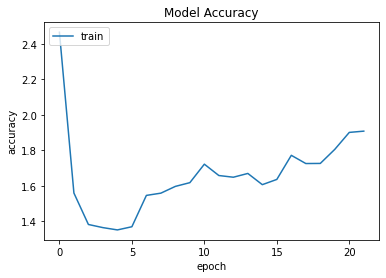

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()